# Recommendation Engine for Board Game Text Data

This project uses data from boardgamegeek.com, gathered by Matt Borthwick (dive-into.info).
The data are around 600k comments on boardgame ratings for around 400 games.  I think these are the 400 most reviewed games on the site. 
Each rating has a score from 1-10, so we can do some sentiment analysis on this.

So a couple possible tasks arise: can you predict the score from a games text?
Can you recommend other possible games based on the text?
Related: does a game mention other games in a positive light?

This project builds off of the Recommendation Project, and the Natural Language Processing on Wikipedia comments.
(The real goal here is to finish an analysis, with a slightly more friendly data set, than idiots screaming racism, misogyny and homophobia.)
This is labelled data for game, so it's a natural fit for employing the same methods as toxicity, and run with that analysis.
In this case, however, our desired output is a numerical score.  As we'll see, this leads to some issues as the scores are skewed.

There is also a smaller parallel attempt to do some simple analysis within PySpark, to familiarize myself with that framework.

## Outline/Planning

What is my ultimate goal here? 
- Build a recommendation engine based on reviews/scores.
- Give score to unrated comments.

My rough plan is to build up a lexicon, tokenize that data, and try to build a Naive Bayes model.  (Maybe later a Recurrent Neural network model?)

Cleaning:
* Tokenize (convert words to indices) 
* Stemming words
* Balancing data set

Embeddings:
These are necessary to reduce the dimensionality of the problem to a scale that will fit in memory.
   * SVD - use SVD on the term-frequency matrix. Will use truncated SVD.
   * word2vec - train vectors for words based on surrounding contexts (can use pre-trained ones, like GLoVE)

Other Analysis possibilities:
* Naive Bayes
    - can find most important words
    - simple, easy to understand baseline.
    
* Support Vector Machine
    - try ensemble method (split the data into batches, and train an SVM on each batch.  Then do a committee vote.)
      This turns O(n_sample^3) scaling into O(n_sample^3/n_batch^2) scaling on the training.
      This is effectively treating the kernel matrix as if it were block-diagonal, as it omits correlations between datasets.
      Perhaps running multiple copies with different random splits would work?

* Linear Regression
   - use regularized linear regression to predict scores based on word counts.
      
* Deep Neural Network
    - Build a network using the term-frequency matrix as inputs.
    - Extends the linear regression methods.  
    - Employ dropout for regularization, alongside L2 penalties.  
     
* Recurrent Neural Network
    - Build up word embeddings (word2vec), or just use the pretrained ones.
    - This one runs at the sentence/paragraph level and keeps the temporal structure.
    - Use LSTM/GRU cells, with a couple layers. 
    - Also dropout for regularization.

* Metrics:
    - RMSE
    - weighted RMSE, to put greater weight on the rarer types of reviews.

# Loading in the data

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD

import pickle

#my modules
from bayes import cond_prob, naive_bayes
from util import clean_up, get_subset, check_predictions
from util import load_glove, sentence_lookup, sent_to_matrix

from deep_network import deep_dropout_NN

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
#load in the actual data, and the testing data.
df = pd.read_csv('data/boardgame-comments-english.csv')
df_real_test=pd.read_csv('data/boardgame-comments-english-test.csv')

In [16]:
#Change Columns.
df.columns=['userID','gameID','rating','comment']
df_real_test.columns=['userID','gameID','comment']

In [4]:
df.head()

   userID  gameID  rating  \
0  172640   24068     7.0   
1   86674   24068     7.0   
2   10643   24068     7.0   
3   31171   24068     7.0   
4  165608   24068     7.0   

                                                                                               comment  
0  Good:  Unique take on the hidden role games. The good and evil team win if they eliminate each o...  
1  A neat social deduction game with multiple teams and winning conditions happening at the same time.  
2  Good hidden roles werewolf style game that can accommodate a lot of players nicely. This game is...  
3  Overall I hate Mafia/Werewolf, but this version is light, fun and fast. There was enough structu...  
4  Fun social deduction exercise that gets merrier the more players participate. The game significa...  

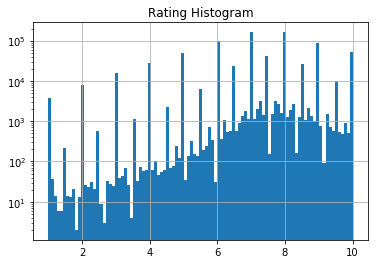

In [420]:
#When are the comments made?
plt.figure()
df['rating'].hist(log=True,bins=101)
plt.title('Rating Histogram')
plt.show()

So let's do more exploration.  

In [5]:
#Number of unique Users
df['userID'].unique().shape

(59789,)

In [6]:
df['gameID'].unique().shape

(402,)

In [7]:
userreview_counts=df.groupby('userID').apply(len)

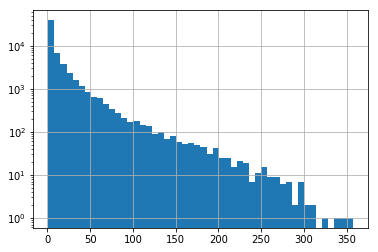

In [421]:
# How many reviews are there per user?
userreview_counts.hist(log=True,bins=50)
plt.show()

So, there are a lot of users with few reviews (again).

This will come up in building a test/train split.  It depends on the task.  Are we trying to build a tool to recommend games? 

In [9]:
#check counts of game reviews
game_groups=df.groupby('gameID')

In [10]:
gamereview_counts=game_groups.apply(len)
gamereview_mean=game_groups['rating'].apply(np.mean)
gamereview_median=game_groups['rating'].apply(np.median)
gamereview_05=game_groups['rating'].apply(lambda x: np.percentile(x,5))
gamereview_95=game_groups['rating'].apply(lambda x: np.percentile(x,95))


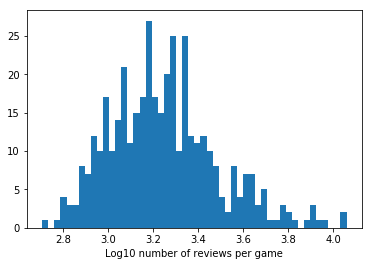

In [422]:
# How many reviews are there per game?
plt.hist(np.log10(gamereview_counts+1),bins=50)
plt.xlabel('Log10 number of reviews per game')
plt.show()


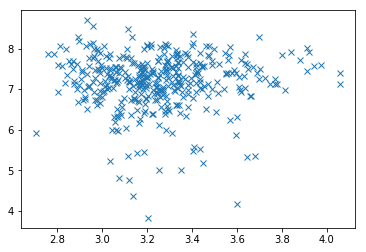

In [423]:
#Any correlation between review number and average score?  Not really.
plt.plot(np.log10(gamereview_counts),gamereview_mean,'x')
plt.show()

In [18]:
#So how many comments are duplicated? 
dup_msk=df.duplicated(subset=['userID','comment'])
df_dup=df.loc[dup_msk]
# (dup_msk.sum(),len(dup_msk))
# Let's isolate those comments, and treat them separately.
# There's around 15k of these, so less than 1%. 

In [22]:
df_dup.tail()

        userID  gameID  rating          comment
841449    2304   31260     9.0      Plays solo.
841450    9807   31260     9.0       Chris owns
841451  150460   31260     9.0           Played
841537  170353   35677     9.5        One game.
841637   53402   70323     7.5  Play with Linus

In [20]:
df.drop_duplicates(subset=['userID','comment'],inplace=True)

So only around 1\% of these comments are duplicated across multiple games.  I'm going to toss these out.
It doesn't make a huge difference, but I doubt there is much value in most of these reviews.  In addition, it fouls up my attempts to estimate positive/negative words.

Next I'll "clean" the comments up.  This is meant to strip out numerical, non-text characters, and markdown.

In [89]:
#cleaning the data
#Can use pandas built in str functionality with regex to eliminate html tags, newlines, non-text characters. 
#Can maybe also eliminate all punctuation?  Makes any

In [92]:
df['comment_clean']=clean_up(df['comment'])
df_real_test['comment_clean']=clean_up(df_real_test['comment'])

# Split data set into train/dev/test sets

At the outset, let's grab 10% of the data for testing, and use the remaining 90% for training.
We'll do parameter selection via k-fold cross validation, with k=5.


In [93]:
#take care of low ratings so minimum is 1. (there are a couple tiny ratings)
msk=df['rating']<1.0;
df.loc[msk,'rating']=1

#create binary labels for rating.
#This is useful for directly porting over binary classification code, and detecting sentiment.  
df['pos']=(df['rating']>8.0)
df['neg']=(df['rating']<5.0)

In [94]:
np.random.seed(seed=4565)
#Split into test/training.
Ntot=len(df)
Ntrain=int(0.9*Ntot)

msk=np.random.random(Ntot)<0.9
df_train=df.loc[msk]
#note this "test" is different from Matt's "realtest" data.
df_test=df.loc[~msk]


Since this is primarily for exploration, I'm going to limit the vectorizer to fairly common words (which occur in more than 50 messages).
Increasing this threshold seems to pull out more meaningful estimates for the conditional probabilities for positive and negative words.

It's also possible to not just use  the raw count vectorizer, but also the TF-IDF, which includes an additional weighting that de-emphasizes common words.  This apparently makes a term-frequency matrix whose spectrum better matches some of the assumptions for the SVD.  

In [95]:
#borrowing from http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
count_vect=CountVectorizer(stop_words='english',lowercase=True,strip_accents='unicode',ngram_range=(1,1),min_df=50)
X_train_counts=count_vect.fit_transform(df_train['comment_clean'])
X_test_counts=count_vect.transform(df_test['comment_clean'])

In [172]:
pickle.dump(count_vect,open('pickled/count_vect','wb'))
pickle.dump(X_train_counts,open('pickled/X_train_counts','wb'))
pickle.dump(X_test_counts,open('pickled/X_test_counts','wb'))

So one of the problems with going to multiple n-grams is the ease with which you start overfitting.  This can be combatted by
playing with the min\_df parameter.  
Maybe I could explore adjusting this size manually, with the size of ngrams.

Given the 2-grams it's probably also possible to do some analysis from the conditional probabilities.  

In [96]:
tfidf_vect=TfidfVectorizer(stop_words='english',lowercase=True,strip_accents='unicode',min_df=50)
X_train_tfidf=tfidf_vect.fit_transform(df_train['comment_clean'])
X_test_tfidf=tfidf_vect.transform(df_test['comment_clean'])

In [171]:
pickle.dump(tfidf_vect,open('pickled/tfidf_vect','wb'))
pickle.dump(X_train_tfidf,open('pickled/X_train_tfidf','wb'))
pickle.dump(X_test_tfidf,open('pickled/X_test_tfidf','wb'))

In [202]:
#transform the real test set
X_realtest_counts=count_vect.transform(df_real_test['comment_clean'])
X_realtest_tfidf=tfidf_vect.transform(df_real_test['comment_clean'])

# Checking the vectorizer and finding common words

I wanted to check that the vectorizer was working by outputting common words, and identifying the "most positive/negative" words, based on their counts.  This was useful as a sanity check.

In [98]:
def find_indicator_words(counts,val,count_vect):
    #Make a dataframe from the vectorizer vocabulary, and sort it so its entries correspond to the vectorizer indices.  
    voc_dict=count_vect.vocabulary_
    voc_df=pd.DataFrame.from_dict(voc_dict,orient='index')
    voc_df1=voc_df.sort_values(by=0)
    #Compute conditional probabilities of toxicity for each word. 
    p_pos,pw_pos,pw_neg = cond_prob( counts, val, csmooth=0.000001)
    #make new dataframe with conditional probabilities for words being toxic, and raw probabilities of occuring in toxic/clean messages
    #Then sort by toxicity.
    X_cond= pw_pos*p_pos/(pw_pos*p_pos + pw_neg*(1-p_pos))
    tf=counts.sum(axis=0)
    df=(counts>0).sum(axis=0)
    word_mat=np.array([tf,df,X_cond,pw_pos,pw_neg]).squeeze()
    word_df=pd.DataFrame(word_mat.T,columns=['term-count','doc-count','pcond','p_hit','p_miss'],index=voc_df1.index)
    word_df.sort_values('pcond',ascending=False,inplace=True)
    print(word_df.head(n=20))
    return word_df

In [99]:
posword_df=find_indicator_words(X_train_counts,df_train['pos'].values,count_vect)

              term-count  doc-count     pcond     p_hit    p_miss
hilinski           101.0       93.0  0.779699  0.000024  0.000002
perfection         383.0      375.0  0.748815  0.000086  0.000009
x1                 207.0       77.0  0.694766  0.000043  0.000006
shards              55.0       54.0  0.693681  0.000011  0.000002
masterpiece       1382.0     1370.0  0.692217  0.000288  0.000040
automa             102.0       85.0  0.690376  0.000021  0.000003
keldons             75.0       72.0  0.677468  0.000015  0.000002
masterful          126.0      126.0  0.666385  0.000025  0.000004
salsa               82.0       71.0  0.654280  0.000016  0.000003
afar                77.0       76.0  0.645688  0.000015  0.000003
wonderfull         103.0       99.0  0.643496  0.000020  0.000003
awesomeness        207.0      203.0  0.635299  0.000040  0.000007
flawless           252.0      249.0  0.633890  0.000048  0.000009
sublime            125.0      124.0  0.622876  0.000024  0.000004
breathtaki

Well, this seems to have found some positive words, as well as some user names, and what I think are actually part of game names ("salsa")


In [100]:
negword_df=find_indicator_words(X_train_counts,df_train['neg'].values,count_vect)

              term-count  doc-count     pcond     p_hit    p_miss
blech              102.0       99.0  0.657465  0.000064  0.000003
spinner             98.0       92.0  0.654377  0.000061  0.000003
yuck               134.0      133.0  0.644830  0.000083  0.000004
redeeming          182.0      180.0  0.639864  0.000111  0.000005
ugh                539.0      534.0  0.569131  0.000295  0.000018
ladders            116.0      115.0  0.521801  0.000058  0.000004
interminable        90.0       90.0  0.511985  0.000045  0.000003
yawn               274.0      262.0  0.489557  0.000130  0.000011
fanboys             55.0       54.0  0.487699  0.000026  0.000002
torture            189.0      183.0  0.486545  0.000089  0.000007
bleh               184.0      182.0  0.478618  0.000085  0.000007
garbage            275.0      264.0  0.476803  0.000127  0.000011
mercifully          73.0       72.0  0.471785  0.000033  0.000003
loathe             211.0      206.0  0.471526  0.000096  0.000009
snakes    

So let's look at what this pulled out for "negative words".

There are expressions of boredom: "interminable, torture, numbingly".
Disgust: "yuck, blech, garbage,ugh"
Dislike:"torture, garbage, hatred, loathe".

And what I think is "snakes and ladders".

Prior to eliminating duplicate comments, this also found user names associated with reviews spamming 1s.  

In [24]:
def find_words(df,st):
    msk=df['comment_clean'].str.contains(st)
    print(df[msk].head())
    print(df[msk].tail())

# K-folds

Let's split the training data into k-folds so we can do some cross-validation for tuning hyper-parameters.
This will primarily show up on tuning the vectorization procedure, and any fitting hyper parameters (regularization).
It can also be used to compare the input stages (convert scores to percentiles).
This will be useful in tuning the inputs like vectorizer size, as well as any dimensionality reduction.
For Naive Bayes, there aren't any parameters, but this will be useful for the neural networks, regression, and SVM.

In [102]:
skf=StratifiedKFold(n_splits=5,random_state=20483)
#grab the first iteration here.
train_index, dev_index=skf.split(df_train, df_train['pos']).__next__()

In [103]:
#Note: really need to use iloc here.  
df_train0=df_train.iloc[train_index]
df_dev0=df_train.iloc[dev_index]

# Naive Bayes Classifier

I want to implement a Naive Bayes classifier as a baseline.  I've written my own version, which I will try to compare to
scikit-learn's version.  (They both return the same result now).  Note that my version is written for only binary classification.

This basically treats the comments in a bag-of-words sense, and drops any correlations between the words.  

* Estimate $p(w|T)$ from counts in term-frequency matrix.
* Use Bayes Rule
  $ P(T|w) = \frac{p(T)p(w|T)}{\text{normalization const}}$

  \begin{equation}
    p(T|\text{words}) = P(T) \prod_{words}\frac{p(w_i|T)}{p(w_i|T)
  \end{equation}

* Use Logarithms, and compare log-odds for positive/non-positive.

So this is a classification point of view.  Ultimately, we want to treat this as a regression problem.
A classification algorithm is a poor fit for this, since it ignores the similarity between adjacent scores. 
Nonetheless, I have a working version, so let's play with that.

In [104]:
#go though this split, and find the hits
actual_pos=df_train0['pos'].values
actual_pos_dev=df_dev0['pos'].values
actual_neg=df_train0['neg'].values
actual_neg_dev=df_dev0['neg'].values
msk=actual_pos
#find indices for both split and hit.
train_hit_msk=train_index[msk]
Xhit = X_train_counts[train_index]
#compute conditional probabilities within this sample
p_hit,pw_hit,pw_miss = cond_prob( Xhit, actual_pos, csmooth=0.000001)
#now compute the bayes factors
pred_pos,prob,logH,logM,log_Hword,log_Mword=naive_bayes(Xhit,pw_hit,pw_miss,p_hit)    

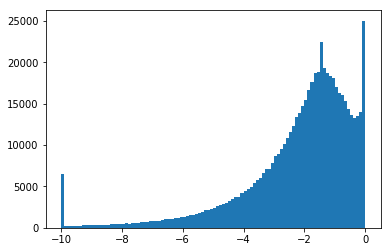

In [424]:
#Plot a histogram of the log probabilities.  
plt.figure()
plt.hist(np.maximum(-10,np.log(prob)),bins=100)
plt.show()

So, this is the probability that a game review is positive.  Most of these are tiny probabilities.  With a larger spike near zero for the cases where the probability is larger than 0.5

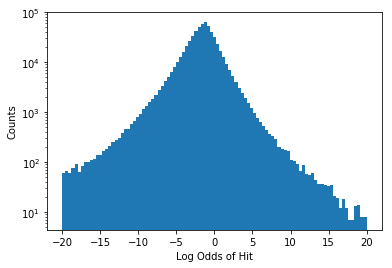

In [425]:
#Plot a histogram of the log-odds 
plt.figure()
bins=np.linspace(-20,20,100)
plt.hist(logH-logM,bins=bins,log=True)
plt.ylabel('Counts')
plt.xlabel('Log Odds of Hit')
plt.show()

This is perhaps more informative: what is the distribution of the log-odds for a positive review, $log(p_H/p_M)$.  It's centered slightly negative, saying few reviews are positive.  There seems to be a fairly symmetric decay as we consider more extreme comments.  Maybe it's related to the length of the comments?

Maybe should also plot length of comments? To what extent are the tails mirroring a similar underlying shape, with long tails, and differing semantic content?

In [107]:
com_len=df_train['comment_clean'].apply(lambda x: len(str.split(x,' ')))

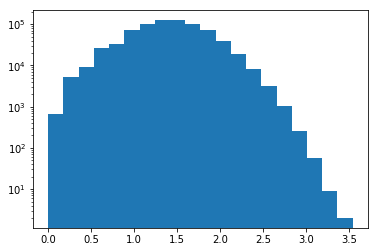

In [428]:
plt.hist(np.log10(com_len),log=True,bins=20)
plt.show()

Not quite.  Looking at a plot of the log length of a comment this looks more log-normal (with a cutoff at zero).  Maybe the probability is being dominated by a few words, so the overall length is not particularly important, but rather the number of words that are counted in the count-vectorizer?  

## Scoring the Naive Bayes

Let's now look at how well the model actually does at capturing positive/negative sentiment.

In [109]:
logloss,score_rates=check_predictions(pred_pos,actual_pos)

Log-loss is 7.357670564439999
AUROC is 0.6654193378236977
(595659, 1) (595659, 1)
True Positive 0.10308918357650938. False Positive 0.07842742240107176
False Negative 0.13459714366776965. True Negative 0.6838862503546492


So let's just use the Scikit-learn version of this, making my own was amusing, but the scikit-learn version can handle multiple classes, and presumably runs faster. 

In [110]:


#alpha is the smoothing parameter for counts.
pos_nb = MultinomialNB(alpha=0.01)
neg_nb= MultinomialNB(alpha=0.01)
pos_nb.fit(X_train_counts[train_index],df_train0['pos'].values)
neg_nb.fit(X_train_counts[train_index],df_train0['neg'].values)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [111]:
#Make predictions on training/dev sets
pred_pos_nb=pos_nb.predict(X_train_counts[train_index])
pred_pos_dev_nb=pos_nb.predict(X_train_counts[dev_index])
pred_neg_nb=neg_nb.predict(X_train_counts[train_index])
pred_neg_dev_nb=neg_nb.predict(X_train_counts[dev_index])

In [112]:
print('Checking Training data')
nb_stats=check_predictions(pred_pos_nb,actual_pos)
nb_stats=check_predictions(pred_neg_nb,actual_neg)

Log-loss is 2.9266067895623347
AUROC is 0.6664242912117463
Log-loss is 7.358192423065742
AUROC is 0.6653899841156704
(595659, 1) (595659, 1)
True Positive 0.027455305804159762. False Positive 0.03895013757871534
False Negative 0.04578290599151528. True Negative 0.8878116506256096
Checking Training data
(595659, 1) (595659, 1)
True Positive 0.10307575307348668. False Positive 0.0784291012139496
False Negative 0.13461057417079236. True Negative 0.6838845715417714


In [113]:
print('Checking dev set')
nb_stats=check_predictions(pred_pos_dev_nb,actual_pos_dev)
nb_stats=check_predictions(pred_neg_dev_nb,actual_neg_dev)

AUROC is 0.6466539733136522
Checking dev set
(148915, 1) (148915, 1)
True Positive 0.09882819057851795. False Positive 0.08022697512003492
False Negative 0.13885773763556392. True Negative 0.6820870966658832
Log-loss is 7.566982054692003
AUROC is 0.6552759119843594
(148915, 1) (148915, 1)
True Positive 0.025544773864284994. False Positive 0.0387670818923547
False Negative 0.0506463418728805. True Negative 0.8850418023704798
Log-loss is 3.088261248189909


So we're evidently nowhere near overfitting.  There's similar performance across both training and dev sets.

As it stands, this tends to miss on a large number of reviews, with both false-positives and false-negatives.

For the "negative reviews", there are far fewer of those, perhaps reflecting the fact that popular games are by and large well received.

## Naive Bayes False Positives and Negatives

Let's now look a bit at the misclassified results and see what we might be missing. 

In [114]:
#fixing shapes to avoid broadcasting
actual_pos=np.reshape(actual_pos,(len(actual_pos),1))
pred_pos=np.reshape(pred_pos,(len(actual_pos),1))    

fp_msk = ((pred_pos==True)&(actual_pos==False))

fn_msk = ((pred_pos==False)&(actual_pos==True))            

In [115]:
df_fn=df_train0[fn_msk][['comment','rating']]
df_fp=df_train0[fp_msk][['comment','rating']]

In [116]:
df_fp.head(n=10)

                                                                                                    comment  \
166417   I rated this one down from a 9 since it never hits the table.  The components are outstanding a...   
166418  Thoughts based on just the first game, will change in future. Interesting command system, could-...   
166425  Without the Broodwar expansion only a 7.  I always liked Starcraft, but i had several disappoint...   
166426  Amazing and innovative game play, set in the StarCraft universe. A tough one to crack, but a joy...   
166427                                Awesome.  See my review at http://www.boardgamegeek.com/thread/211664   
166430  A fun, deep gameplay experience. Definitely Fantasy Flight as it took a while to learn those dar...   
166432  PILE OF SHAME  Intimidating but seems brilliant. Haven't gotten it out for a proper game yet tho...   
166433  English 1st edition Great condition (4 games)  House without pets or smoke.  The box includes th...   
1

At an initial scan, these seem to be very positive reviews, but for people who perhaps are fairly critical in how these use the scale.  (one conneisseurs 7, is another neophytes 10.)  Our criteria for positive is score>8.  And this is mischaracherizing 8.0 scores as being greater than 8.
This hits at one of the difficulties here: predicting exactly how a user will use the rating system is hard, an expecting sub-0.5 resolution is perhaps a bit much. 

So this suggests that perhaps we need to scale a game and user's scores in order to get a decent estimate at an "objective" numerical rating.   

In [117]:
df_fn.head(n=10)

                                                                                                    comment  \
167535      Shiny. Must misbehave more often.  So much Browncoat fun in one small box. Great solitaire too.   
167540                                            Fun, fun, fuuuuuuun! You can't take this game from me...    
167546                                                                                                Next    
167548  Fun game, not essential to have seen the TV series, but will add some additional enjoyment as yo...   
167549  Understand why people would not like the game. I don't know if I would say it's a "great" game, ...   
167553  This game is extremely faithful to the concept show and a whole lot of fun.  As I think others h...   
167554  I love this game and the gameplay has a true to the show feel.  The only downside is time betwee...   
167555  Game plays a little long.  Made some house rules to speed it up a bit.  Plays well as a Firefly ...   
1

Hmm, nothing obviously negative about this.  Perhaps not as effusive?  Really need to look at the scores on this.
It seems like this subset of printed reviews is for the Firefly game, where fans are trying to offset negative scores. 

## Naive Bayes to Predict Score

For fun, let's try putting each review into a bucket based on the score, and build a Naive Bayes classifier for each bin.
This is a very simple way to try doing the regression. 

In [118]:
#Assign each half-integer bucket to an integer label.  e.g. .0-.5 is bucket 0, 0.5-1 -> 1, 1.0-1.5 ->3
#Treat those as independent classes 
Ytrain=np.floor(df_train['rating']*2).values.astype(int)
Ytrain0=Ytrain[train_index]
Ydev0=Ytrain[dev_index]

In [119]:
nb_all = MultinomialNB(alpha=0.01)
nb_all.fit(X_train_counts[train_index],Ytrain0)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [243]:
pred_train_nb_all=nb_all.predict(X_train_counts[train_index])/2
pred_dev_nb_all=nb_all.predict(X_train_counts[dev_index])/2
pred_nb_all=nb_all.predict(X_train_counts)/2

In [391]:
def errors(x,y,w=None):
    rmse=np.sqrt(np.mean( (x-y)*(x-y)))
    mae=np.mean(np.abs(x-y))
    results={'RMSE':rmse,'MAE':mae}
    if (w is not None ):
        wrmse = np.sqrt(np.sum( w*(x-y)*(x-y))/np.sum(w))
        results['WRMSE']=wrmse
    return results

In [368]:
errors(pred_train_nb_all,df_train0['rating'])

{'MAE': 1.0885627274497354, 'RMSE': 1.5811913489883482}

In [123]:
np.sum(pred_train_nb_all==df_train0['rating'].values)/len(df_train0)

0.28499023770311538

In [129]:
errors(7.2,df_train0['rating'])

{'MAD': 1.2970124246420365, 'RMSE': 1.6933319051527553}

Let's check this against the development set.

In [186]:
errors(pred_dev_nb_all,df_dev0['rating'])

{'MAD': 1.1618099698485775, 'RMSE': 1.6334742919950866}

In [131]:
errors(7.2,df_dev0['rating'])

{'MAD': 1.307295365947063, 'RMSE': 1.7027968731059731}

So, it does a bit better than the super simple guess.
One of the downsides of this particular problem is that the scores are fairly similar.
These are by and large, good games, so they have good scores. 
People also use the rating scale inconsistently, so there is quite a bit of noise in the mapping from sentiment to score.  I think this is the largest issue with this dataset. 

I think this (like the previous rating experiment) will struggle to push below this noise floor.

### Running on the Test Set and outputting to CSV

In [196]:
#now predict all counts
pred_realtest_nb=nb_all.predict(X_realtest_counts)/2
df_real_test['nb']=pred_realtest_nb

In [197]:
df_real_test['const']=7.2

In [198]:
df_real_test[['userID','gameID','nb']].to_csv('data/nb_test_pred.csv',index=False)
df_real_test[['userID','gameID','const']].to_csv('data/const_test_pred.csv',index=False)

# Regularized Linear Regression

We could just face the fact this is a regression problem, and build a linear regressor on the term-frequency matrix.
This basically fits a model of the form:
\begin{equation}
  y^{(i)} = \sum_j w_j f_j^{(i)}
\end{equation}
where $f_j^{(i)}$ is the count for token $j$ in comment $i$.  The weights $w_i$ are what we are fitting for, with a cost function
\begin{equation}
    J = N^{-1}\sum_i ( \hat{y}^{(i)}-y^{(i)})^2.
\end{equation}
I'll try to use a couple regularizations here: ridge and lasso regression which add penalities $\alpha_2\sum_iw_i^2$  and $\alpha_1\sum_i |w_i|$ respectively. It looks like the parameters are quite sensitive.

I'm going to fit these hyperparameters via cross-validation.  

In [140]:
Y=df_train['rating'].values

In [138]:
np.logspace(-6,-1,num=3)

array([  1.00000000e-06,   3.16227766e-04,   1.00000000e-01])

In [154]:
parameters={'alpha':np.logspace(-6,2,num=8)}
ridge=linear_model.Ridge()
lasso=linear_model.Lasso()

## Ridge GridSearch Cross-Validation

This will use the scikit-learn function for the classifier to pick the regularization threshold for ridge regression.
Note that this is fairly slow, so I just used a subset of the data.

In [157]:
#do automated grid-search via k-fold cross validation
ridge_cv=GridSearchCV(ridge,parameters,n_jobs=2)
ridge_cv.fit(X_train_counts[:100000], Y[:100000])

GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'alpha': array([  1.00000e-06,   1.38950e-05,   1.93070e-04,   2.68270e-03,
         3.72759e-02,   5.17947e-01,   7.19686e+00,   1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [158]:
ridge_cv.best_params_

{'alpha': 100.0}

In [197]:
#takes a while with the full matrix.   
ridgecv_pred2=ridge_cv.predict(X_train_counts)

In [196]:
ridgecv_pred_realtest=ridge_cv.predict(X_realtest_counts)

In [190]:
errors(ridgecv_pred2,Y)

{'MAD': 1.1067650147227397, 'RMSE': 1.4621549029290382}

In [200]:
df_real_test['Rpred_cv']=ridgecv_pred_realtest
df_real_test[['userID','gameID','Rpred_cv']].to_csv('predictions/ridgecv_test_pred.csv',index=False)

## Lasso Regression

This is just a quick attempt to fit a lasso regression.  This just uses a slightly hand tuned guess. 
(This might also be out of date)

In [89]:
#takes a while with the full matrix.   
lasso.fit(X_train_counts[train_index], Y[train_index])

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [97]:
Rpred=ridge.predict(X_train_counts[train_index])
Rpred_dev=ridge.predict(X_train_counts[dev_index])

In [90]:
Lpred=lasso.predict(X_train_counts[train_index])
Lpred_dev=lasso.predict(X_train_counts[dev_index])

In [107]:
#Now run it on the test data. 
Lpred_real_test=lasso.predict(X_realtest_counts)
df_real_test['Lpred']=Lpred_real_test
df_real_test[['userID','gameID','Lpred']].to_csv('data/lasso_test_pred.csv',index=False)

In [91]:
print('Lasso train error:',errors(Lpred,Y[train_index]))
print('Lasso dev error:',errors(Lpred_dev,Y[dev_index]))

Lasso train error: {'RMSE': 1.5964427269415096, 'MAD': 1.2083386291499489}
Lasso dev error: {'RMSE': 1.6041091242369758, 'MAD': 1.2177823248817377}


In [256]:
print('Ridge train error:',errors(Rpred,Y[train_index]))
print('Ridge dev error:',errors(Rpred_dev,Y[dev_index]))

Ridge train error: {'RMSE': 1.4167511640051815, 'MAD': 1.0732287882234155}
Ridge dev error: {'RMSE': 1.4550694344298802, 'MAD': 1.1025028099380467}


In [244]:
len(pred_train_nb_all),len(Y[train_index])

(595659, 595659)

# Dimensionality Reduction

Let's use the truncated SVD for dimensionality reduction.
Apparently TF-IDF matrix is superior to straight term frequency matrix for this purpose  (more closely matches assumptions in the SVD about the noise.)
This should use a sparse algorithm (and preserve that sparsity) in the resulting matrices. 

I should may also symmetrize transformation (as suggested in paper comparing hyperparameters between word2vec and older SVD methods) for word embeddings. They suggest using $T=U \Lambda V = (U \Lambda^{1/2}) (\Lambda^{1/2} V)$ for the projection.
So if we have a term-frequency matrix, $M$, the transformed matrix should be given by $M'=M(U \Lambda^{1/2})$, rather than $M''=MU$.

The SVD will be used primarily for the neural network (which needs a dense input).  In the interests of comparison, it would probably be fairest to repeat the linear regression for these transformed variables as well to get a sense of how the network is doing.

In [161]:

#took around 5 min on laptop.
TSVD=TruncatedSVD(n_components=200,n_iter=20,random_state=2847)
TSVD.fit(X_train_tfidf)

TruncatedSVD(algorithm='randomized', n_components=200, n_iter=20,
       random_state=2847, tol=0.0)

In [203]:
#actually transform the results 
X_train_trans=TSVD.transform(X_train_tfidf)
X_test_trans=TSVD.transform(X_test_tfidf)
X_realtest_trans=TSVD.transform(X_realtest_tfidf)         

In [165]:
pickle.dump(TSVD,open('pickled/TSVD','wb'))

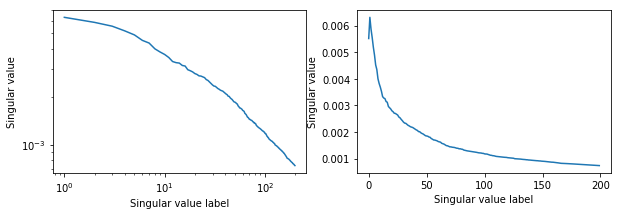

In [429]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.loglog(TSVD.explained_variance_)
plt.xlabel('Singular value label')
plt.ylabel('Singular value')
plt.subplot(122)
plt.plot(TSVD.explained_variance_)
plt.xlabel('Singular value label')
plt.ylabel('Singular value')
plt.show()

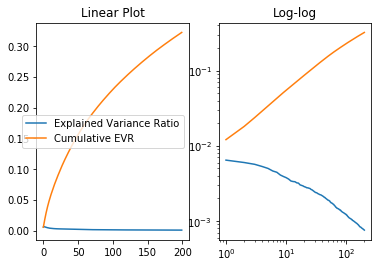

In [431]:
x=np.linspace(1,200)
plt.subplot(121)
plt.plot(TSVD.explained_variance_ratio_,label='Explained Variance Ratio')
plt.plot(np.cumsum(TSVD.explained_variance_ratio_),label='Cumulative EVR')
plt.legend()
plt.title('Linear Plot')
plt.subplot(122)
plt.loglog(TSVD.explained_variance_ratio_)
plt.loglog(np.cumsum(TSVD.explained_variance_ratio_))
plt.title('Log-log')
plt.show()

So looks like power-law decay in the spectrum. We're primarily interested in using this
for dimensionality reduction.  Ideally, I'd pick some reasonable threshold for keeping a
certain fraction of the explained variance.
(Could estimate a power law tail, compute threshold to capture that percentage).
Looking at the cumulative EVR, it scales somewhere between linearly and square-root (at least initially).
Should be able to reason out the cutoff so we get 0.9 of the EVR.

But for now, we'll just set the threshold to be 200, as a suitably small arbitrary choice.
We will next use the transformed results in a feedforward neural network.  

In [170]:
#actually transform the dev/test data.
X_test_trans=TSVD.transform(X_test_tfidf)

# Deep Network

Another idea is to build a deep neural network on the term-frequency matrix, effectively running with nonlinear extensions to the earlier work. 

This will use the reduced term-frequency matrix after the Truncated SVD.

Another approach to vectorizing is to use pre-trained wordvectors for each token.  Then just use the average for the whole comment.  That approach loses all of the semantic ordering, but it is simple to implement.
A more complex model could preserve the temporal order of this, using a RNN.  

In [175]:
#Ignore the "error about serializing - this is a known problem with saving models created using 
#modules like fully connected, since their components are not named.
#The models are saved, and the computations work.

X=X_train_trans[train_index]
# just try predicting output score scaled from [0-1]
Y0=Y[train_index]/10
save_name='./tf_models/deep_relu_drop'

In [176]:
dNN=deep_dropout_NN(X.shape)

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


In [ ]:
#actually train the model - this is slow. 
dNN.run_graph(X,Y0,save_name)

In [177]:
#model_name='tf_models/deep_relu_drop-{}'.format(dNN.n_iter)
dNN.keep_prob=1
model_name='./tf_models/deep_relu_drop-{}'.format(10000)
dnn_pred2=dNN.predict_all(model_name,X_train_trans)
dnn_pred2=dnn_pred2.reshape(-1)


newer predict
INFO:tensorflow:Restoring parameters from ./tf_models/deep_relu_drop-10000


In [178]:
#find values larger than 10, and values less than 0, and limit them. 
msk=dnn_pred2>1
dnn_pred2[msk]=1
msk=dnn_pred2<0
dnn_pred2[msk]=0.05


In [179]:
#Check scores on training data
print('Train',errors(dnn_pred2[train_index]*10,Y[train_index]))

Train {'RMSE': 1.5597578664428968, 'MAD': 1.1769857055904218}


In [180]:
print('Dev',errors(dnn_pred2[dev_index]*10,Y[dev_index]))

Dev {'RMSE': 1.5749093350166528, 'MAD': 1.1890763885231692}


In [181]:
print('Const',errors(7.2,df_train['rating']))

Const {'RMSE': 1.6952291289531762, 'MAD': 1.2990690156648506}


Let's look at those errors now, and compare the results for differing methods.
This is looking at the difference between predicted and actual scores for the training set.

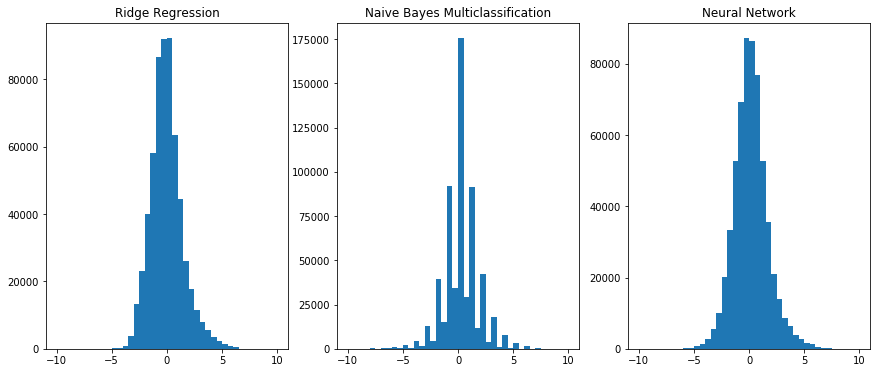

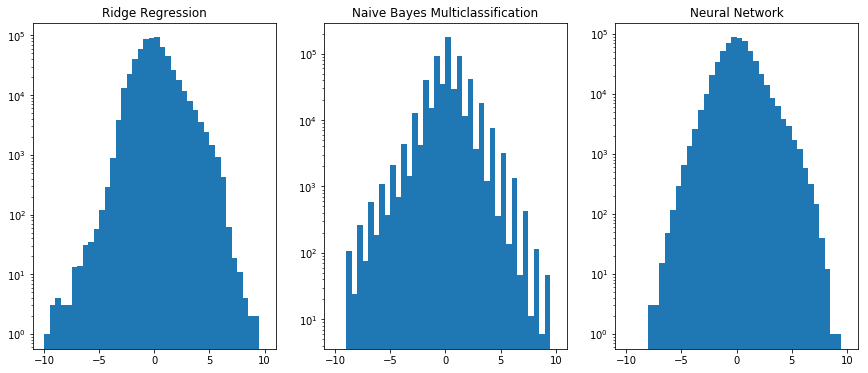

In [436]:
def plot_pred_errors(log_flag=False):
    bins=np.linspace(-10,10,41)
    plt.figure(figsize=(20,6))
    plt.title('Raw Distributions')
    # plt.subplot(141)
    # plt.hist(Lpred-Y[train_index],bins=bins,log=True)
    # plt.title('Lasso Regression')
    plt.subplot(142)
    plt.hist(ridgecv_pred2[train_index]-Y[train_index],bins=bins,log=log_flag)
    plt.title('Ridge Regression')
    plt.subplot(143)
    plt.hist(pred_nb_all[train_index]-Y[train_index],bins=bins,log=log_flag)
    plt.title('Naive Bayes Multiclassification')
    plt.subplot(144)
    plt.hist(dnn_pred2[train_index]*10-Y[train_index],bins=bins,log=log_flag)
    plt.title('Neural Network')
    plt.show()
    
plot_pred_errors(log_flag=False)
plot_pred_errors(log_flag=True)

So eyeballing the errors, it's clear the neural network and the ridge regression are somewhat skew - reflecting the fact that most scores are bunched around the mean.  Those predictions are relatively high, since they miss the negative tail.  The naive Bayes method is notably discretized, but does have a few more large errors.  

In [209]:
dnn_realtest_pred=dNN.predict_all(model_name,X_realtest_trans)*10
dnn_realtest_pred=dnn_realtest_pred.reshape(-1)

newer predict
INFO:tensorflow:Restoring parameters from ./tf_models/deep_relu_drop-10000


In [210]:
df_real_test['DNN']=dnn_realtest_pred
df_real_test[['userID','gameID','DNN']].to_csv('predictions/DNN_test_pred.csv',index=False)

Some interesting differences in terms of the shapes of the output distributions based on method.

Right now the network doesn't know about the scoring.  Some fiddling to round the scores and truncate them could be done.  
But, I think ultimately the oddities in how the data is scored (clustered around 7, with variability in terms of who is scoring is the problem).

So ways to fix that:
- Normalize the scores.
- Instead predict score quantiles so we're targetting a flat distribution?  
- Include categorical variables for user/game?
- Perhaps some variety of boosting?  Look at mis-classified results, develop tweak/model to characterize those? Perhaps normalize/scale the scores by user and by game? 

Well, we still haven't really tried tuning these models yet.  These are just parameters picked from giving decent results, rather than optimal ones.

In addition, all of these methods are just trying to work on the word-count matrices.  This throws away the semantics and just looks for a few indicator words.  An extension

Let's think about the use-case here. Why would I care about getting the score exactly right? Wouldn't I care more about guessing positive/negative based on the text.  What am I aiming for here?  A better recommender tool?  In that case maybe some named entity recognition would be needed?
So if I say "For fans of Settlers of Catan", or SOC it picks that up?
This usecase comes from reading copious amounts of reviews, where a band is mentioned in passing, as having a similar sound.
It would be nice to have an automated tool to make those recommendations. 

# Ensembling Results

As a simple step, let's ensemble these results together.  I need some positive weighted $\alpha_i$, for each models predictions.

I'll aim to optimize not just the RMSE, but the weighted RMSE.

Scores given by:
\begin{equation}
x_{ens} = \sum_{\text{models} i} \alpha_i x_i.
\end{equation}

With metric 
\begin{equation}
   J = \frac{1}{n_{\text{obs}}}\sum_{\text{obs} j}^{N_{\text{obs}}} [ w_i (x_j-y_j)^2]
\end{equation}

If $N_i$ is the number of scores in a bin $i$, e.g. $1.0< x<2.0$, then we'll define the weight to be $N_i^{-1}$.
This gives greater weight to the rarer scores further away from the mean.  Others in the group used bootstrapping to equalize the datasets, to similar results.  

In [370]:
def calc_weights(Y):
    """computes weighted square error based on inverse number of """
    weights=np.zeros(Y.shape)
    Yint = Y.astype(int)
    for i in range(1,11):
        msk=(Yint==i)
        w = np.sum(msk)
        weights[msk]=1.0/w
        print(i,w,1.0/w, 1.0/np.sqrt(w))
    weights=weights/np.max(weights)    
    return weights
weights=calc_weights(df_train['rating'])

9 95149 1.05098319478e-05 0.00324188709671
10 46075 2.17037438958e-05 0.00465872771214
1 3773 0.000265041081368 0.0162800823514
2 8005 0.000124921923798 0.0111768476682
3 15434 6.47920176234e-05 0.00804934889438
4 27759 3.60243524623e-05 0.00600202902878
5 51789 1.93091196972e-05 0.00439421434357
6 118924 8.40873162692e-06 0.00289978130674
7 198061 5.04894956604e-06 0.00224698677478
8 179605 5.56777372568e-06 0.00235961304575


In [437]:
def ensemble(X,Y,W,niter=100,lr=0.001):
    """fit an ensemble model to data using 
    gradient descent on weighted least square error.
    """
    nval,nmodel=X.shape

    alpha=np.ones((nmodel,1))/nmodel
    Jbest=nval*10
    alpha_best=alpha
    for j in range(niter):
        for n in range(nmodel):
            aX = np.dot(X,alpha).reshape(-1)
            #compute score.
            #J=np.sum( W*(aX-Y)*(aX-Y))/np.sum(W)
            dJ = np.sum( W*X[:,n]*(aX-Y))/np.sum(W)
            an = np.abs(alpha[n] - lr*dJ)
            alpha[n]= an
            alpha=alpha/sum(alpha)
        #recompute after step    
        aX = np.dot(X,alpha).reshape(-1)
        #compute score.
        J=np.sum( W*(aX-Y)*(aX-Y))/np.sum(W)
            
        #print out results    
        if (j%50==0):
            print("iter, score, grad: {}, {}, {}".format(j,J,dJ))
            print("alpha_best:",alpha_best.T)
        #store optimal results    
        if (J<=Jbest):    
            alpha_best=alpha
            dJbest=Jbest-J            
            Jbest=J
            if (abs(dJbest)<1E-6):
                break
            
    score_vec=aX = np.dot(X,alpha_best).reshape(-1)
    return score_vec,alpha_best


In [366]:
#make a score-matrix where each column is a rating from a model.
score_matrix=np.array([dnn_pred2*10,ridgecv_pred2,pred_nb_all]).T
train_ratings=df_train.iloc[train_index]['rating'].values
train_weights=weights[train_index]

In [438]:
%pdb off
ens_scores,alpha=ensemble(score_matrix[train_index],train_ratings,train_weights,niter=200,lr=0.001)
ens_scores_1,alpha_1=ensemble(score_matrix[train_index],train_ratings,np.ones(train_ratings.shape),niter=200,lr=0.001)

Automatic pdb calling has been turned OFF
iter, score, grad: 0, 6.0337447619005165, 5.919192524580007
alpha_best: [[ 0.32602819  0.33333333  0.33333333]]
iter, score, grad: 50, 5.834860085338396, 5.950488018407283
alpha_best: [[ 0.28387039  0.29717791  0.41188714]]
iter, score, grad: 100, 5.532551863082963, 6.025231537469176
alpha_best: [[ 0.18445168  0.21050041  0.59855394]]
iter, score, grad: 150, 5.631322004551734, 6.182943115742226
alpha_best: [[ 0.1051715   0.14052757  0.74826389]]
iter, score, grad: 0, 1.9300049878093803, 0.5126613561918683
alpha_best: [[ 0.33274339  0.33333333  0.33333333]]
iter, score, grad: 50, 1.9294802989956665, 0.5107075300458144
alpha_best: [[ 0.32977296  0.33529773  0.33434405]]
iter, score, grad: 100, 1.928940793427188, 0.5085843565384972
alpha_best: [[ 0.32664281  0.3373993   0.33537758]]
iter, score, grad: 150, 1.9283875522731715, 0.5062819771453245
alpha_best: [[ 0.32334713  0.33964486  0.33643293]]


In [402]:
ens_scores=np.dot(score_matrix,alpha).reshape(-1)
ens_scores_1=np.dot(score_matrix,alpha_1).reshape(-1)

In [ ]:
So we just trained a tiny ensemble with weights chosen to optimize either the weighted RMSE, or the unweighted RMSE.

In [439]:
print(errors(ens_scores[dev_index],df_train['rating'].values[dev_index],weights[dev_index]))
print(errors(np.mean(score_matrix[dev_index],axis=1),df_train['rating'].values[dev_index],weights[dev_index]))
print(errors(ens_scores_1[dev_index],df_train['rating'].values[dev_index],weights[dev_index]))

{'RMSE': 2.1582570618533428, 'MAE': 1.6596171513520734, 'WRMSE': 3.5682284813211593}
{'RMSE': 1.4105096480142751, 'MAE': 1.062556382297134, 'WRMSE': 2.5291781461647549}
{'RMSE': 1.9922342380657683, 'MAE': 1.5425678516910184, 'WRMSE': 3.494170374436611}


So ensembling the results can reduce the RMSE by around a tenth of a point.  As expected, the ensembling exceeds the performance on any of the prior models.  

Holy Massive Overfitting Batman!  These constants are evidently overfitting on the training data. 
When we look at the results from the withheld dev set, the errors on the "improved" ensembles are higher than any of the individuals.  Only the simple averaging improed the RMSE, or at least did no harm.  Hmm.

# Recurrent Neural Network

So let's try the current flavour of the month approach: a recurrent neural network.
Let's try something similar, with initially a single layer leaky ReLU layer.

The idea is that the network parses each word of the sentence (to better capture logical structure).
Each word needs an index.  Initially this is an index in the vocabulary V, where $V\sim10^6$ or more.  That's an infeasibly large matrix.
We need some form of dimensionality reduction.  Either by picking the most distinctive words (which actually appear in multiple messages),
or by projecting down via SVD.

I think making this efficient requires loading the word embedding matrix onto the GPU
- use the embedding lookup function
- use a batch generator.
- add an estimator interface to allow sklearn to optimize hyperparameters.
- add variable for length of comment.
- look up inluded EOS markers?
- hierarchical neural network?  RNN sentences to vec, RNN sentence vec to doc, doc2vec?
- 
- make a pipeline (comment-to-vec, regression)
- make a new sklearn metric for weighted least squares.
- make estimator interface
- do cross-validation - probably enough parameters for a random search to be worthwhile. 
- tune hyperparameters (layers, size, stop-words)


In [184]:


glove_vec,glove_dict=load_glove()

In [185]:
df_train['comment_vec_index']=df_train['comment_clean'].apply(lambda x:sentence_lookup(x,glove_dict))

/home/jonathan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
mat=sent_to_matrix(df_train.loc[20,'comment_vec_index'],glove_vec)